In [1]:
import pandas as pd
import pymc3 as pm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline



This will allow me to print the correct decay equation. All we need is the correct decay constant from Bayes. Also, don't revert notebooks
The question is, how do we model multiple decays? The decay constants will form a Normal distibution under Bayes treatment. Can start each thermal decay curve at zero, then add all the data sets. This will yield a decay rate for the whole set, which can be refit to each curve with starting point. 

This can be checked by comparing to each individual decay constant and average constants. 

## Find decay constant with Bayes regression, using one data set


In [2]:
#Read data into dataframe 
df1 = pd.read_csv('../data/2014.12.17 OneEigth in Si post', header=None , names = ['Time', 'Temp'],  delimiter = '\t')

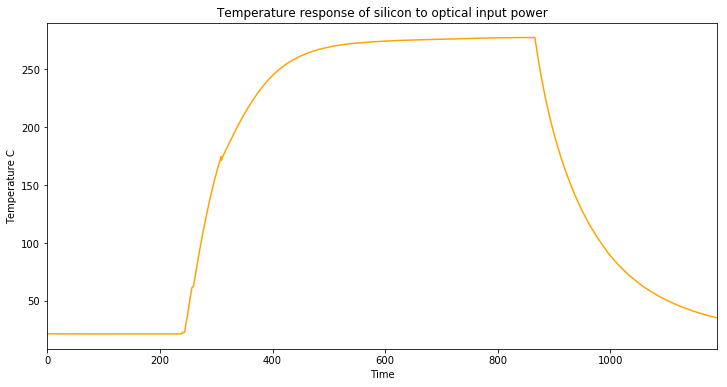

In [3]:
#Plotting Temperature response as a function of time 
df1.plot(x = 'Time', y = 'Temp', color = 'orange', legend = False, figsize=(12, 6))
plt.title("Temperature response of silicon to optical input power")
plt.ylabel("Temperature C",);

From the plot above, we see that the power source was turned on sometime after 200 seconds. The sample reached steady state temperature at about 900 s, with a T ~ 250 C. After ~900 s the input optical power source is turned off; and the temperature decays back down to room temperature. This decay is a function of the materials emissivity. 

In [4]:
#Find room temperature 
T0 = df1.Temp.min()
T0

21.344999999999999

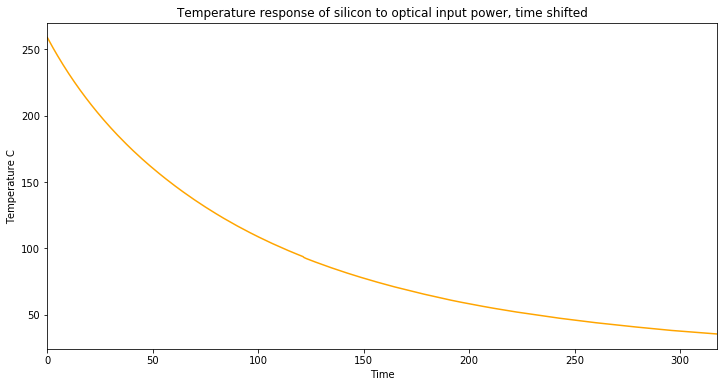

In [5]:
#Next we need to isolate the thermal decay region 
df1 = df1[ (df1.Time > 850) & (df1.Temp < 260)]
df1.Time -= df1.Time.min() #sets decay start time to zero 
df1.plot(x = 'Time', y = 'Temp', color = 'orange', legend = False, figsize=(12, 6))
plt.title("Temperature response of silicon to optical input power, time shifted")
plt.ylabel("Temperature C",);

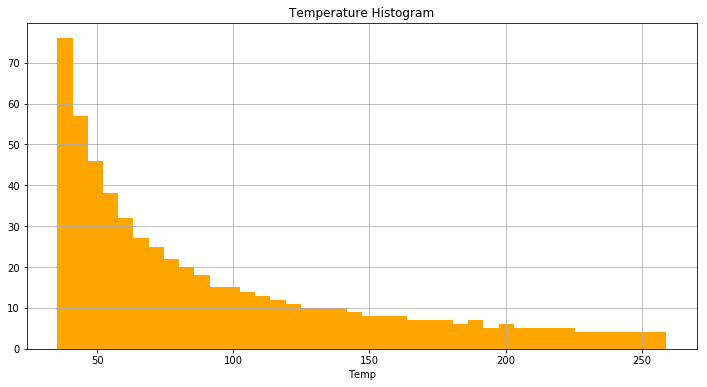

In [6]:
#Plot histogram of data
df1.Temp.hist(color='orange', figsize=(12,6), bins=40)
plt.title("Temperature Histogram")
plt.xlabel("Temp");

The histogram above hints that we should use an exponential decay probability density function. D ~ Exp(c_decay) for data and  c_decay ~ Nomal(0,1) for prior. 

100%|██████████| 5500/5500 [00:03<00:00, 1381.03it/s]



c_decay:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.011            0.000            0.000            [0.010, 0.011]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.010          0.010          0.011          0.011          0.011



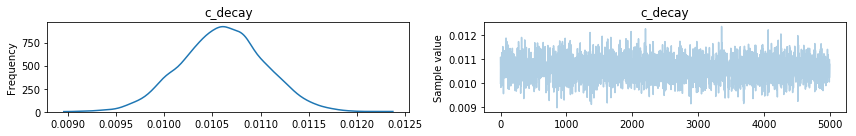

In [7]:
#Invoking Bayes statistics to find the decay contsant of thermal decay data 
with pm.Model():
    # Prior 
    c_decay = pm.Uniform('c_decay', 0, 1) #model constant uniform distribution 
     
    # likelihood  
    data1 = np.array(df1.Temp) #convert data frame to array
    data_fit = pm.Exponential('data_fit', lam = c_decay, observed=data1) 

    # Inference
    #start = find_MAP( ) # Find starting value by optimization
    step = pm.NUTS() # Instantiate MCMC sampling algorithm
    trace = pm.sample(5000, step, tune=500)
    pm.summary(trace)
    pm.traceplot(trace)

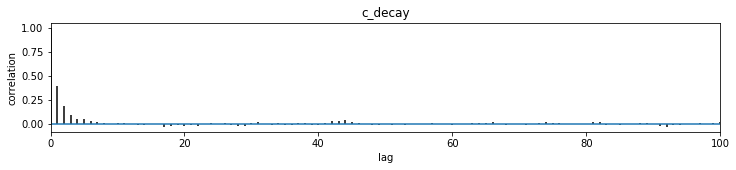

In [8]:
pm.plots.autocorrplot(trace);

Now we can simulate a curve this decay constant and plot it against data. 

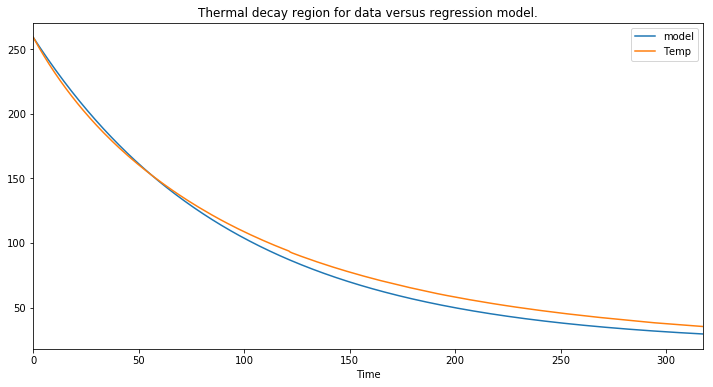

In [8]:
lam_1 = trace['c_decay'].mean()
a = df1.Temp.max() - T0 #Value at t = 0 
df1['model'] = a*np.exp(-(lam_1)*( df1['Time'] )) + T0
df1.plot(x = 'Time', y = ['model', 'Temp'], figsize=(12, 6), title = 'Thermal decay region for data versus regression model.');

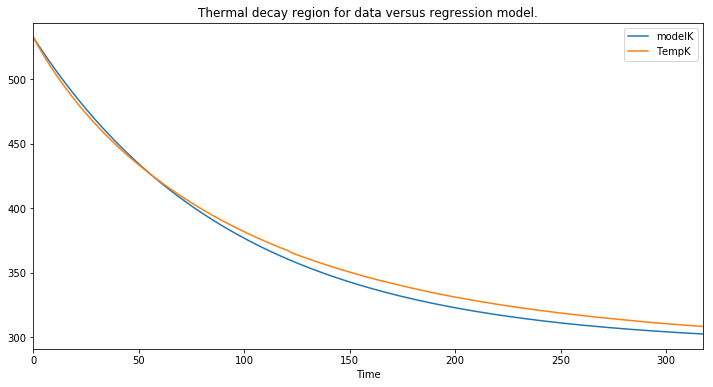

In [9]:
#Convert Temp to Kelvin and replotting curve
df1['TempK'] = df1.Temp + 273.15  
T0K = T0 + 273.15
lam_1 = trace['c_decay'].mean()
aK = df1.TempK.max() - T0K #Value at t = 0 
df1['modelK'] = aK*np.exp(-(lam_1)*( df1['Time'] )) + T0K
df1.plot(x = 'Time', y = ['modelK', 'TempK'], figsize=(12, 6), title = 'Thermal decay region for data versus regression model.');

Using thermal balance equations we can plot emissivity as a function of temperature. 

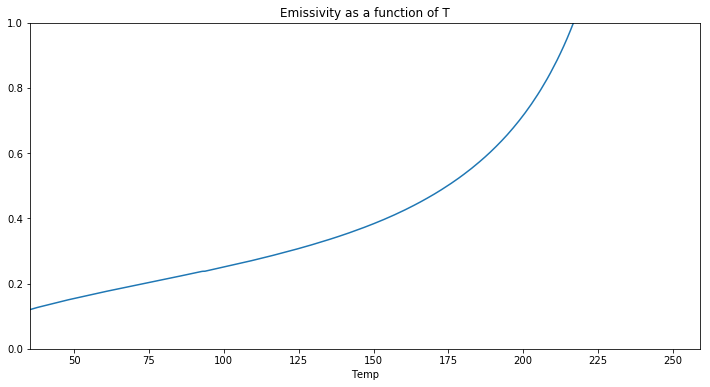

In [70]:
#Constants: sigma [J/(m^2*s*K^4)]; m, mass in kilograms; T0 in K; area, area in m^2
area = 0.0002 
sigma = 5.670373e-08  
m = 0.0000693

#Make temperature ascending 
df1.sort_values(['Temp'], ascending=True, inplace =True)

#heat capacity for silicon as a function of temperature. Constants from Endo, 2003. 
c = lambda x: 660.00925 + 0.0857*x - 0.00000823*x**2

df1['em'] = m*c(df1.TempK)*( ( df1.TempK - T0K ) / (area*sigma*(df1.Time )) )*( 1 / (df1.TempK**4 - T0K**4))
df1.plot(x = 'Temp', y = 'em', figsize=(12, 6), legend = False, title = 'Emissivity as a function of T', ylim = (0,1) );

In [53]:
-m*c(df1.TempK[1750])*( ( df1.TempK[1755] -  df1.TempK[1750]) / (area*sigma*(df1.Time[1755] -df1.Time[1750] )) )*( 1 / (df1.TempK[1755]**4 - T0K**4))

0.22396558657102345

In [55]:
-m*c(df1.TempK[1630])*( ( df1.TempK[1630] -  df1.TempK[1626]) / (area*sigma*(df1.Time[1630] -df1.Time[1626] )) )*( 1 / (df1.TempK[1630]**4 - T0K**4))

0.18169203092416311

In [99]:
df1[400:450]

,Time,Temp,model,TempK,modelK,em
400,102.947,106.339,101.083378,379.489,374.233378,0.263878
401,102.410,106.747,101.538891,379.897,374.688891,0.264758
402,101.874,107.157,101.996150,380.307,375.146150,0.265643
403,101.338,107.573,102.456017,380.723,375.606017,0.266532
404,100.802,107.987,102.918506,381.137,376.068506,0.267433
405,100.266,108.398,103.383632,381.548,376.533632,0.268350
406,99.730,108.825,103.851410,381.975,377.001410,0.269257
407,99.194,109.245,104.321855,382.395,377.471855,0.270184
408,98.657,109.668,104.795868,382.818,377.945868,0.271122
409,98.121,110.104,105.271698,383.254,378.421698,0.272051


In [73]:
m*700*( ( 1 ) / (area*sigma*( 5 )) )*( 1 / (309**4 - T0K**4))

0.53636455350904955

In [77]:
m*700*( ( 6 ) / (area*sigma*( 2 )) )*( 1 / (522**4 - T0K**4))

0.19231645018489571

In [80]:
m*700*( ( 10 ) / (area*sigma*( 4.8 )) )*( 1 / (506**4 - T0K**4))

0.15355884244608139

In [105]:
m*700*( ( 11 ) / (area*sigma*( 4.8 )) )*( 1 / ((519)**4 - T0K**4))

0.15073096608790032

In [125]:
m*700*( ( 1 ) / (area*sigma*( 5 )) )*( 1 / (309**4 - (308 - T0K)**4))

0.093839851883666794

In [123]:
m*700*( ( 5.16 ) / (area*sigma*( 5.3 )) )*( 1 / ( 402**4 - (397 - T0K)**4))

0.16013973666612241

In [126]:
m*700*( ( 10 ) / (area*sigma*( 4.8 )) )*( 1 / (506**4 - (496 - T0K)**4))

0.1394468261761086

In [127]:
m*700*( ( 6 ) / (area*sigma*( 2 )) )*( 1 / (522**4 - (522-T0K)**4))

0.17930337855137415

In [128]:
m*700*( ( 11 ) / (area*sigma*( 4.8 )) )*( 1 / ((530)**4 - (519-T0K)**4))

0.12836604585083444

In [185]:
m*700*( ( 8.2 ) / (area*sigma*( 8.2 )) )*( 1 / ((389.8-300)**4 + (389)**4))

0.1862771693363291

In [183]:
m*700*( ( 5.16 ) / (area*sigma*( 5.3 )) )*( 1 / ( (402-300)**4 + ( 397)**4))

0.16692182468999353

In [181]:
m*700*( ( 10 ) / (area*sigma*( 4.8 )) )*( 1 / ((506-300)**4 + (496)**4))

0.14298428632931862

In [191]:
m*700*( ( 300 -11 ) / (area*sigma*( 4.8 )) )*( 1 / (-(530 )**4 + (300)**4))

-3.6373366171530863